In [ ]:
import zipfile
from pathlib import Path

# Path to your uploaded ZIP file (make sure it's in /content)
zip_path = "/content/audio_files.zip"  # << change if path differs

# Output folder where images will be extracted
extract_dir = Path("/content/multimodal_audio/audio")

# Create directory if it doesn’t exist
extract_dir.mkdir(parents=True, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir.resolve()}")

✅ Dataset extracted to: /content/multimodal_audio/audio


In [ ]:
import zipfile
from pathlib import Path

# Path to your uploaded ZIP file (make sure it's in /content)
zip_path = "/content/Multimodal Captioning Dataset.zip"  # << change if path differs

# Output folder where images will be extracted
extract_dir = Path("/content/Multimodal_Captioning_Dataset")

# Create directory if it doesn’t exist
extract_dir.mkdir(parents=True, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir.resolve()}")

✅ Dataset extracted to: /content/Multimodal_Captioning_Dataset


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Colab-ready: Tri-modal training (5-fold) -> saves logits, probs, y_true, fold_ids
# Paste entire block into one Colab cell and run.

!pip install -q timm transformers librosa soundfile scikit-learn

import os, gc, random, time
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

import soundfile as sf
import librosa
import timm
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# -------------------- CONFIG --------------------
CSV_PATH = "/content/clips_with_audio_clean2.csv"   # adjust if needed
TEXT_COL = "Updated_Question"                      # or "Question_summ"
IMG_COL  = "Image_path_final"                      # or "Image_path"
AUDIO_COL= "audio_path"
LABEL_COL= "probable_classes"

EMB_DIR = "/content/wav2vec_tri_embs"
os.makedirs(EMB_DIR, exist_ok=True)

IMG_SIZE = 300
BATCH_SIZE = 4
EPOCHS = 20
FOLDS = 5
SEED = 42
TARGET_SR = 16000
AUDIO_SEC = 3
NUM_WORKERS = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)

# -------------------- LOAD CSV --------------------
df = pd.read_csv(CSV_PATH)
print("Original rows:", len(df))

# basic filter: need text,img,audio,label
mask = df.get(TEXT_COL).notna() & df.get(IMG_COL).notna() & df.get(AUDIO_COL).notna() & df.get(LABEL_COL).notna()
df = df[mask].reset_index(drop=True)
print("Rows after filter:", len(df))

# -------------------- LABELS -> multi-hot Y --------------------
raw_labels = df[LABEL_COL].astype(str).tolist()
all_labels = sorted({lbl.strip() for row in raw_labels for lbl in row.split(",") if lbl.strip()})
label_to_idx = {lab:i for i,lab in enumerate(all_labels)}
print("Num distinct labels:", len(all_labels))
print("Example labels:", all_labels[:12])

num_labels = len(all_labels)
Y = np.zeros((len(df), num_labels), dtype=np.float32)
for i, r in enumerate(raw_labels):
    for tok in r.split(","):
        tok = tok.strip()
        if tok in label_to_idx:
            Y[i, label_to_idx[tok]] = 1.0

df["row_id"] = np.arange(len(df))
print("Multi-label matrix shape:", Y.shape)

# save y_true for later CI computation
np.save("/content/y_true.npy", Y)
print("Saved /content/y_true.npy")

# -------------------- TF-IDF (text features) --------------------
texts = df[TEXT_COL].fillna("").astype(str).tolist()
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=2)
X_text_sparse = tfidf.fit_transform(texts)
X_text = X_text_sparse.toarray().astype(np.float32)   # dense for convenience
text_dim = X_text.shape[1]
print("TF-IDF dim:", text_dim)

# -------------------- wav2vec2: precompute audio embeddings --------------------
print("Loading wav2vec2 (this may download ~350MB)...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device).eval()
emb_dim = wav2vec.config.hidden_size
print("wav2vec emb dim:", emb_dim)

def extract_wav2vec_emb(row_id, audio_path):
    out_path = os.path.join(EMB_DIR, f"emb_{row_id}.npy")
    if os.path.exists(out_path):
        return
    try:
        y, sr = sf.read(audio_path, dtype="float32")
    except Exception as e:
        # fallback to librosa
        try:
            y, sr = librosa.load(audio_path, sr=None)
            y = y.astype("float32")
        except Exception as e2:
            print(f"[WARN] audio load failed for {audio_path}: {e} / {e2}")
            np.save(out_path, np.zeros(emb_dim, dtype=np.float32))
            return
    if y is None:
        np.save(out_path, np.zeros(emb_dim, dtype=np.float32))
        return
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != TARGET_SR:
        try:
            y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
            sr = TARGET_SR
        except Exception:
            # if resample fails, pad/trim to something
            pass
    needed = TARGET_SR * AUDIO_SEC
    if len(y) < needed:
        y = np.pad(y, (0, needed - len(y)))
    else:
        y = y[:needed]
    with torch.no_grad():
        inp = processor(y, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
        input_values = inp["input_values"].to(device)
        out = wav2vec(input_values)
        hid = out.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy().astype(np.float32)
    np.save(out_path, hid)

print("Precomputing wav2vec embeddings...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    extract_wav2vec_emb(int(row.row_id), row[AUDIO_COL])
print("Wav2vec embeddings saved to", EMB_DIR)

# -------------------- Image transforms --------------------
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(0.12,0.12,0.08,0.04),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -------------------- Dataset --------------------
class TriModalDataset(Dataset):
    def __init__(self, df_sub, X_text, Y_full, transform, emb_dir):
        self.df_sub = df_sub.reset_index(drop=True)
        self.X_text = X_text
        self.Y = Y_full
        self.transform = transform
        self.emb_dir = emb_dir
    def __len__(self): return len(self.df_sub)
    def __getitem__(self, idx):
        row = self.df_sub.iloc[idx]
        rid = int(row["row_id"])
        # image
        try:
            img = Image.open(row[IMG_COL]).convert("RGB")
            img = self.transform(img)
        except Exception:
            img = torch.zeros(3, IMG_SIZE, IMG_SIZE)
        # text dense
        x_text = torch.from_numpy(self.X_text[rid])
        # audio emb
        emb_path = os.path.join(self.emb_dir, f"emb_{rid}.npy")
        if os.path.exists(emb_path):
            emb = np.load(emb_path).astype(np.float32)
        else:
            emb = np.zeros(emb_dim, dtype=np.float32)
        emb = torch.from_numpy(emb)
        y = torch.from_numpy(self.Y[rid])
        return img, x_text, emb, y

# -------------------- Model --------------------
class ImgEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # create model with num_classes=0 to return features
        self.backbone = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        # determine output dim by running a dummy through the backbone
        with torch.no_grad():
            dummy = torch.randn(1,3,IMG_SIZE,IMG_SIZE)
            feat = self.backbone(dummy)
            self.out_dim = feat.shape[1]
    def forward(self, x):
        return self.backbone(x)

class TriModalNet(nn.Module):
    def __init__(self, text_dim, audio_dim, num_classes):
        super().__init__()
        self.img_enc = ImgEncoder()
        self.text_proj = nn.Sequential(nn.Linear(text_dim, 512), nn.ReLU(), nn.LayerNorm(512), nn.Dropout(0.3))
        self.audio_proj = nn.Sequential(nn.Linear(audio_dim, 512), nn.ReLU(), nn.LayerNorm(512), nn.Dropout(0.3))
        fusion_dim = self.img_enc.out_dim + 512 + 512
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 1024), nn.ReLU(), nn.LayerNorm(1024), nn.Dropout(0.4),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, img, txt, aud):
        img_feat = self.img_enc(img)
        txt_feat = self.text_proj(txt)
        aud_feat = self.audio_proj(aud)
        x = torch.cat([img_feat, txt_feat, aud_feat], dim=1)
        return self.head(x)

# -------------------- Metrics helper --------------------
def compute_micro_macro_from_probs(y_true, y_prob, thr=0.5, eps=1e-9):
    y_pred = (y_prob >= thr).astype(int)
    # micro
    tp = ((y_true==1) & (y_pred==1)).sum()
    fp = ((y_true==0) & (y_pred==1)).sum()
    fn = ((y_true==1) & (y_pred==0)).sum()
    micro = 2*tp / (2*tp + fp + fn + eps)
    # macro: average per-class f1 (skip classes with zero support)
    C = y_true.shape[1]
    f1s = []
    for c in range(C):
        yt = y_true[:,c]
        yp = y_pred[:,c]
        tp_c = ((yt==1) & (yp==1)).sum()
        fp_c = ((yt==0) & (yp==1)).sum()
        fn_c = ((yt==1) & (yp==0)).sum()
        den = (2*tp_c + fp_c + fn_c + eps)
        if (yt.sum() == 0):
            continue
        f1s.append(2*tp_c / den)
    macro = float(np.mean(f1s)) if len(f1s)>0 else 0.0
    return float(micro), float(macro)

# -------------------- 5-Fold training --------------------
primary = Y.argmax(axis=1)  # simple stratification
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

N = len(df)
oof_logits = np.zeros((N, num_labels), dtype=np.float32)
fold_ids = np.zeros(N, dtype=np.int32)

fold_iter = list(skf.split(np.arange(N), primary))
for fold, (tr_idx, vl_idx) in enumerate(fold_iter, start=1):
    print(f"\n=== FOLD {fold}/{FOLDS} ===")
    fold_ids[vl_idx] = fold

    tr_df, vl_df = df.iloc[tr_idx].reset_index(drop=True), df.iloc[vl_idx].reset_index(drop=True)

    tr_ds = TriModalDataset(tr_df, X_text, Y, train_tf, EMB_DIR)
    vl_ds = TriModalDataset(vl_df, X_text, Y, eval_tf, EMB_DIR)
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    vl_loader = DataLoader(vl_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # build model
    model = TriModalNet(text_dim=text_dim, audio_dim=emb_dim, num_classes=num_labels).to(device)

    # compute pos_weight from training split
    y_tr = Y[tr_idx]
    pos = y_tr.sum(axis=0) + 1e-6
    neg = (y_tr.shape[0] - pos) + 1e-6
    pos_weight = torch.tensor(neg/pos, dtype=torch.float32, device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

    best_micro = 0.0
    best_path = f"/content/tri_best_fold{fold}.pth"

    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for imgs, txts, embs, ys in tr_loader:
            imgs = imgs.to(device)
            txts = txts.to(device)
            embs = embs.to(device)
            ys = ys.to(device)
            optimizer.zero_grad()
            logits = model(imgs, txts, embs)
            loss = criterion(logits, ys)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()

        # validation per epoch
        model.eval()
        val_logits = []
        val_trues = []
        with torch.no_grad():
            for imgs, txts, embs, ys in vl_loader:
                imgs = imgs.to(device); txts = txts.to(device); embs = embs.to(device)
                logits = model(imgs, txts, embs).cpu().numpy()
                val_logits.append(logits)
                val_trues.append(ys.numpy())
        val_logits = np.vstack(val_logits)
        val_trues = np.vstack(val_trues)
        val_probs = 1.0 / (1.0 + np.exp(-val_logits))
        micro, macro = compute_micro_macro_from_probs(val_trues, val_probs, thr=0.5)
        print(f"Fold {fold} Epoch {epoch}: Loss {running_loss/len(tr_loader):.4f} | micro-F1 = {micro:.4f} | macro-F1 = {macro:.4f}")
        if micro > best_micro + 1e-6:
            best_micro = micro
            torch.save(model.state_dict(), best_path)
            print(f"  -> saved best model for fold {fold} (micro {best_micro:.4f})")

    # load best and compute OOF logits (raw)
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()
    all_logits = []
    with torch.no_grad():
        for imgs, txts, embs, ys in vl_loader:
            imgs = imgs.to(device); txts = txts.to(device); embs = embs.to(device)
            logits = model(imgs, txts, embs).cpu().numpy()
            all_logits.append(logits)
    all_logits = np.vstack(all_logits)
    if all_logits.shape[0] != len(vl_idx):
        # safety: if batch sizes or ordering mismatch, resize accordingly
        print(f"[WARN] fold {fold} vl len mismatch {all_logits.shape[0]} vs {len(vl_idx)}; trimming/padding as needed")
        n_min = min(all_logits.shape[0], len(vl_idx))
        oof_logits[vl_idx[:n_min]] = all_logits[:n_min]
        if all_logits.shape[0] < len(vl_idx):
            # pad remaining with zeros
            oof_logits[vl_idx[all_logits.shape[0]:]] = 0.0
    else:
        oof_logits[vl_idx] = all_logits

    print(f"Fold {fold} done. Best micro-F1 on val: {best_micro:.4f}")
    # free memory
    del model, tr_loader, vl_loader, tr_ds, vl_ds, optimizer
    torch.cuda.empty_cache(); gc.collect()

# save fold ids and logits and probs
np.save("/content/trimodal_oof_logits.npy", oof_logits)
np.save("/content/trimodal_oof_probs.npy", (1.0/(1.0+np.exp(-oof_logits))))
np.save("/content/fold_ids.npy", fold_ids)
print("Saved: /content/trimodal_oof_logits.npy, /content/trimodal_oof_probs.npy, /content/fold_ids.npy")

# Global threshold search (micro-F1)
best_thr, best_micro = 0.5, 0.0
for thr in np.linspace(0.3, 0.8, 11):
    probs = 1.0/(1.0+np.exp(-oof_logits))
    micro, macro = compute_micro_macro_from_probs(Y, probs, thr=thr)
    if micro > best_micro:
        best_micro = micro; best_thr = thr
print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {best_micro:.4f}")

final_micro, final_macro = compute_micro_macro_from_probs(Y, 1.0/(1.0+np.exp(-oof_logits)), thr=best_thr)
print(f"Final OOF micro-F1: {final_micro:.4f} | macro-F1: {final_macro:.4f}")

# done
print("All done. Files saved in /content/")


Device: cuda
Original rows: 404
Rows after filter: 404
Num distinct labels: 18
Example labels: ['cyanosis', 'dry scalp', 'edema', 'eye inflamation', 'eye redness', 'foot swelling', 'hand lump', 'itichy eyelid', 'knee swelling', 'lip swelling', 'mouth ulcer', 'neck swelling']
Multi-label matrix shape: (404, 18)
Saved /content/y_true.npy
TF-IDF dim: 2000
Loading wav2vec2 (this may download ~350MB)...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wav2vec emb dim: 768
Precomputing wav2vec embeddings...


100%|██████████| 404/404 [00:12<00:00, 33.17it/s]


Wav2vec embeddings saved to /content/wav2vec_tri_embs

=== FOLD 1/5 ===


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Fold 1 Epoch 1: Loss 1.1866 | micro-F1 = 0.4106 | macro-F1 = 0.3213
  -> saved best model for fold 1 (micro 0.4106)
Fold 1 Epoch 2: Loss 1.0093 | micro-F1 = 0.4986 | macro-F1 = 0.4350
  -> saved best model for fold 1 (micro 0.4986)
Fold 1 Epoch 3: Loss 0.5365 | micro-F1 = 0.6049 | macro-F1 = 0.5135
  -> saved best model for fold 1 (micro 0.6049)
Fold 1 Epoch 4: Loss 0.2810 | micro-F1 = 0.7480 | macro-F1 = 0.6681
  -> saved best model for fold 1 (micro 0.7480)
Fold 1 Epoch 5: Loss 0.1795 | micro-F1 = 0.7229 | macro-F1 = 0.6587
Fold 1 Epoch 6: Loss 0.1020 | micro-F1 = 0.7195 | macro-F1 = 0.6128
Fold 1 Epoch 7: Loss 0.0670 | micro-F1 = 0.7339 | macro-F1 = 0.6594
Fold 1 Epoch 8: Loss 0.0636 | micro-F1 = 0.7521 | macro-F1 = 0.6764
  -> saved best model for fold 1 (micro 0.7521)
Fold 1 Epoch 9: Loss 0.0345 | micro-F1 = 0.7242 | macro-F1 = 0.6368
Fold 1 Epoch 10: Loss 0.0197 | micro-F1 = 0.7715 | macro-F1 = 0.6722
  -> saved best model for fold 1 (micro 0.7715)
Fold 1 Epoch 11: Loss 0.0245 | 

In [ ]:
# ✅ Text-Only Model (TF-IDF → MLP) with Final F1 Summary
# Produces: text_only_oof_logits.npy and prints best threshold + micro/macro F1

!pip install -q scikit-learn

import os, numpy as np, pandas as pd, gc, torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader

SEED = 42
CSV_PATH = "/content/clips_with_audio_clean2.csv"
TEXT_COL = "Updated_Question"
LABEL_COL = "probable_classes"
FOLDS = 5
BATCH_SIZE = 16
EPOCHS = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Load CSV
df = pd.read_csv(CSV_PATH)
df = df[df[TEXT_COL].notna() & df[LABEL_COL].notna()].reset_index(drop=True)
texts = df[TEXT_COL].fillna("").astype(str).tolist()

# Label binarization
raw_labels = df[LABEL_COL].astype(str).tolist()
all_labels = sorted({tok.strip() for row in raw_labels for tok in row.split(',') if tok.strip()})
label_to_idx = {lab: i for i, lab in enumerate(all_labels)}
Y = np.zeros((len(df), len(all_labels)), dtype=np.float32)
for i, row in enumerate(raw_labels):
    for lab in row.split(','):
        lab = lab.strip()
        if lab in label_to_idx:
            Y[i, label_to_idx[lab]] = 1.0
num_labels = len(all_labels)

# TF-IDF features
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), min_df=2)
X_text_sparse = tfidf.fit_transform(texts).astype(np.float32)
X = X_text_sparse.toarray()
input_dim = X.shape[1]

# Dataset
class TextOnlyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

# Model
class TextMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LayerNorm(512),
            nn.Linear(512, out_dim)
        )
    def forward(self, x): return self.net(x)

# F1 calculation
def f1_micro_macro(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro

# Training
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
oof_logits = np.zeros((len(X), num_labels), dtype=np.float32)

for fold, (tr_idx, vl_idx) in enumerate(kf.split(X), start=1):
    print(f"\n=== Fold {fold} ===")
    tr_ds = TextOnlyDataset(X[tr_idx], Y[tr_idx])
    vl_ds = TextOnlyDataset(X[vl_idx], Y[vl_idx])
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    vl_loader = DataLoader(vl_ds, batch_size=BATCH_SIZE)

    model = TextMLP(input_dim, num_labels).to(device)
    pos = Y[tr_idx].sum(axis=0) + 1e-6
    neg = len(tr_idx) - pos + 1e-6
    pos_weight = torch.tensor(neg / pos, dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)

    best_micro = 0.0
    for epoch in range(1, EPOCHS+1):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        all_logits, all_y = [], []
        with torch.no_grad():
            for xb, yb in vl_loader:
                out = model(xb.to(device))
                all_logits.append(out.cpu())
                all_y.append(yb)
        logits = torch.cat(all_logits).numpy()
        y_true = torch.cat(all_y).numpy()
        prob = 1 / (1 + np.exp(-logits))
        micro, _ = f1_micro_macro(y_true, prob)
        print(f"Fold {fold} Epoch {epoch}: micro-F1 = {micro:.4f}")
        if micro > best_micro:
            best_micro = micro
            best_logits = logits.copy()

    oof_logits[vl_idx] = best_logits
    print(f"Fold {fold} done. Best micro-F1: {best_micro:.4f}")
    del model; torch.cuda.empty_cache(); gc.collect()

# Final threshold search
best_thr, best_micro, best_macro = 0.5, 0.0, 0.0
for thr in np.linspace(0.3, 0.8, 11):
    micro, macro = f1_micro_macro(Y, 1 / (1 + np.exp(-oof_logits)), thr)
    if micro > best_micro:
        best_micro, best_macro, best_thr = micro, macro, thr

print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {best_micro:.4f} | macro-F1: {best_macro:.4f}")

np.save("/content/text_only_oof_logits.npy", oof_logits)
print("Saved: /content/text_only_oof_logits.npy")



=== Fold 1 ===
Fold 1 Epoch 1: micro-F1 = 0.5412
Fold 1 Epoch 2: micro-F1 = 0.6462
Fold 1 Epoch 3: micro-F1 = 0.7004
Fold 1 Epoch 4: micro-F1 = 0.6976
Fold 1 Epoch 5: micro-F1 = 0.6992
Fold 1 Epoch 6: micro-F1 = 0.7094
Fold 1 Epoch 7: micro-F1 = 0.7124
Fold 1 Epoch 8: micro-F1 = 0.7048
Fold 1 Epoch 9: micro-F1 = 0.7152
Fold 1 Epoch 10: micro-F1 = 0.7248
Fold 1 Epoch 11: micro-F1 = 0.7314
Fold 1 Epoch 12: micro-F1 = 0.7211
Fold 1 Epoch 13: micro-F1 = 0.7285
Fold 1 Epoch 14: micro-F1 = 0.7356
Fold 1 Epoch 15: micro-F1 = 0.7302
Fold 1 Epoch 16: micro-F1 = 0.7302
Fold 1 Epoch 17: micro-F1 = 0.7264
Fold 1 Epoch 18: micro-F1 = 0.7289
Fold 1 Epoch 19: micro-F1 = 0.7248
Fold 1 Epoch 20: micro-F1 = 0.7206
Fold 1 done. Best micro-F1: 0.7356

=== Fold 2 ===
Fold 2 Epoch 1: micro-F1 = 0.4693
Fold 2 Epoch 2: micro-F1 = 0.6048
Fold 2 Epoch 3: micro-F1 = 0.6772
Fold 2 Epoch 4: micro-F1 = 0.7125
Fold 2 Epoch 5: micro-F1 = 0.7082
Fold 2 Epoch 6: micro-F1 = 0.7087
Fold 2 Epoch 7: micro-F1 = 0.6941
Fold

In [ ]:
# Colab-ready: Image-only baseline — EfficientNet-B3 (no resaving y_true/fold_ids)
!pip install -q timm scikit-learn torchvision

import os, gc, random, numpy as np, pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# ---------------- CONFIG ----------------
CSV_PATH = "/content/clips_with_audio_clean2.csv"
IMG_COL = "Image_path_final"
LABEL_COL = "probable_classes"
FOLDS = 5
SEED = 42
IMG_SIZE = 300
BATCH_SIZE = 8
EPOCHS = 12
LR = 3e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------------- Load + Process ----------------
df = pd.read_csv(CSV_PATH)
mask = df[IMG_COL].notna() & df[LABEL_COL].notna()
df = df[mask].reset_index(drop=True)
print("Filtered rows:", len(df))

# load Y and fold_ids from tri-model run
Y = np.load("/content/y_true.npy")
fold_ids = np.load("/content/fold_ids.npy")
n_labels = Y.shape[1]

# multi-label argmax for primary class (used to verify stratification)
primary = Y.argmax(axis=1)

# ---------------- Transforms + Dataset ----------------
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

class ImgDataset(Dataset):
    def __init__(self, df_slice, transform, Y):
        self.df = df_slice.reset_index(drop=True)
        self.transform = transform
        self.Y = Y
        self.indices = df_slice.index.values
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row[IMG_COL]).convert("RGB")
            img = self.transform(img)
        except:
            img = torch.zeros(3, IMG_SIZE, IMG_SIZE)
        y = torch.tensor(self.Y[self.indices[idx]])
        return img, y

# ---------------- Model ----------------
import timm
class ImgOnlyNet(nn.Module):
    def __init__(self, n_labels):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, n_labels)
        )
    def forward(self, x): return self.head(self.backbone(x))

# ---------------- Metrics ----------------
def f1_micro_macro(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro

# ---------------- Train + Eval ----------------
oof_logits = np.zeros_like(Y, dtype=np.float32)

for fold in range(1, FOLDS+1):
    print(f"\n=== Fold {fold} ===")
    vl_idx = np.where(fold_ids == fold)[0]
    tr_idx = np.where(fold_ids != fold)[0]

    model = ImgOnlyNet(n_labels).to(device)
    tr_ds = ImgDataset(df.iloc[tr_idx], train_tf, Y)
    vl_ds = ImgDataset(df.iloc[vl_idx], eval_tf, Y)
    tr_loader = DataLoader(tr_ds, BATCH_SIZE, shuffle=True)
    vl_loader = DataLoader(vl_ds, BATCH_SIZE, shuffle=False)

    y_tr = Y[tr_idx]
    pos = y_tr.sum(axis=0) + 1e-6
    neg = y_tr.shape[0] - pos + 1e-6
    pos_weight = torch.tensor(neg / pos, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    best_micro = 0.0
    best_logits = None

    for ep in range(1, EPOCHS+1):
        model.train()
        for x, y in tr_loader:
            optimizer.zero_grad()
            logits = model(x.to(device))
            loss = criterion(logits, y.to(device).float())
            loss.backward()
            optimizer.step()

        model.eval()
        all_logits = []
        all_true = []
        with torch.no_grad():
            for x, y in vl_loader:
                logits = model(x.to(device))
                all_logits.append(logits.cpu())
                all_true.append(y)
        logits_vl = torch.cat(all_logits).numpy()
        y_true_vl = torch.cat(all_true).numpy()
        probs = 1 / (1 + np.exp(-logits_vl))
        micro, macro = f1_micro_macro(y_true_vl, probs)
        print(f"Fold {fold} Epoch {ep}: micro-F1={micro:.4f} | macro-F1={macro:.4f}")
        if micro > best_micro:
            best_micro = micro
            best_logits = logits_vl.copy()

    oof_logits[vl_idx] = best_logits
    print(f"Fold {fold} done. Best val micro-F1: {best_micro:.4f}")
    del model; torch.cuda.empty_cache(); gc.collect()

# ---------------- Save + Threshold Search ----------------
np.save("/content/image_only_oof_logits.npy", oof_logits)
print("Saved /content/image_only_oof_logits.npy")

oof_probs = 1 / (1 + np.exp(-oof_logits))
best_thr, best_micro, best_macro = 0.5, 0.0, 0.0
for thr in np.linspace(0.3, 0.8, 41):
    micro, macro = f1_micro_macro(Y, oof_probs, thr)
    if micro > best_micro:
        best_micro, best_macro, best_thr = micro, macro, thr

print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {best_micro:.4f} | macro-F1: {best_macro:.4f}")


Device: cuda
Filtered rows: 404

=== Fold 1 ===
Fold 1 Epoch 1: micro-F1=0.3754 | macro-F1=0.3475
Fold 1 Epoch 2: micro-F1=0.4165 | macro-F1=0.3666
Fold 1 Epoch 3: micro-F1=0.4353 | macro-F1=0.3689
Fold 1 Epoch 4: micro-F1=0.4529 | macro-F1=0.3850
Fold 1 Epoch 5: micro-F1=0.4709 | macro-F1=0.3966
Fold 1 Epoch 6: micro-F1=0.4651 | macro-F1=0.3948
Fold 1 Epoch 7: micro-F1=0.4812 | macro-F1=0.4030
Fold 1 Epoch 8: micro-F1=0.4742 | macro-F1=0.4029
Fold 1 Epoch 9: micro-F1=0.4771 | macro-F1=0.4038
Fold 1 Epoch 10: micro-F1=0.4863 | macro-F1=0.4094
Fold 1 Epoch 11: micro-F1=0.4801 | macro-F1=0.4062
Fold 1 Epoch 12: micro-F1=0.4836 | macro-F1=0.3971
Fold 1 done. Best val micro-F1: 0.4863

=== Fold 2 ===
Fold 2 Epoch 1: micro-F1=0.4168 | macro-F1=0.3731
Fold 2 Epoch 2: micro-F1=0.4500 | macro-F1=0.3892
Fold 2 Epoch 3: micro-F1=0.5367 | macro-F1=0.4472
Fold 2 Epoch 4: micro-F1=0.5836 | macro-F1=0.4837
Fold 2 Epoch 5: micro-F1=0.5789 | macro-F1=0.4812
Fold 2 Epoch 6: micro-F1=0.5863 | macro-F1=0

In [ ]:
# Colab-ready: Audio-only baseline (wav2vec2 embeddings -> MLP), saves /content/audio_only_oof_logits.npy
# Re-uses existing y_true.npy and fold_ids.npy if present; otherwise builds them and saves.

!pip install -q transformers librosa soundfile scikit-learn tqdm

import os, gc, random, time
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import librosa
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# ------------------ CONFIG ------------------
CSV_PATH = "/content/clips_with_audio_clean2.csv"
AUDIO_COL = "audio_path"
LABEL_COL = "probable_classes"
EMB_DIR = "/content/wav2vec_tri_embs"   # directory with emb_{row_id}.npy (if present)
os.makedirs(EMB_DIR, exist_ok=True)

FOLDS = 5
SEED = 42
TARGET_SR = 16000
AUDIO_SEC = 3
BATCH_SIZE = 16
EPOCHS = 20
LR = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# ------------------ LOAD CSV & BUILD LABELS ------------------
df = pd.read_csv(CSV_PATH)
print("Original rows in CSV:", len(df))

# filter rows with valid audio path and labels
mask = df[AUDIO_COL].notna() & df[LABEL_COL].notna()
df = df[mask].reset_index(drop=True)
print("Rows after audio+label filter:", len(df))

# create multi-label matrix Y (N, C)
raw_labels = df[LABEL_COL].astype(str).tolist()
all_labels = sorted({tok.strip() for s in raw_labels for tok in s.split(",") if tok.strip()})
label_to_idx = {lab:i for i,lab in enumerate(all_labels)}
print("Num distinct labels:", len(all_labels))
N = len(df)

Y = np.zeros((N, len(all_labels)), dtype=np.int8)
for i, s in enumerate(raw_labels):
    for tok in s.split(","):
        t = tok.strip()
        if t in label_to_idx:
            Y[i, label_to_idx[t]] = 1
print("y shape:", Y.shape)

# save y_true if not present (useful for downstream CI code)
if not os.path.exists("/content/y_true.npy"):
    np.save("/content/y_true.npy", Y.astype(np.int8))
    print("Saved /content/y_true.npy")
else:
    print("/content/y_true.npy already exists; will reuse it.")

# ------------------ fold_ids (reproducible splits) ------------------
if os.path.exists("/content/fold_ids.npy"):
    fold_ids = np.load("/content/fold_ids.npy")
    print("Loaded existing fold_ids.npy")
else:
    print("Creating fold assignments (KFold).")
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    fold_ids = np.zeros(N, dtype=np.int32)
    for fold, (_, vl_idx) in enumerate(kf.split(np.arange(N)), start=1):
        fold_ids[vl_idx] = fold
    np.save("/content/fold_ids.npy", fold_ids)
    print("Saved /content/fold_ids.npy")

# ------------------ wav2vec2 processor/model ------------------
print("Loading wav2vec2 processor+model (may download ~350MB)...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE).eval()
emb_dim = wav2vec.config.hidden_size
print("wav2vec embed dim:", emb_dim)

# ------------------ Ensure audio embeddings exist (emb_{i}.npy) ------------------
def build_audio_emb_if_missing(i, audio_path):
    out_path = os.path.join(EMB_DIR, f"emb_{i}.npy")
    if os.path.exists(out_path):
        return
    try:
        y, sr = sf.read(audio_path, dtype="float32")
    except Exception as e1:
        try:
            y, sr = librosa.load(audio_path, sr=None)  # fallback
            y = y.astype("float32")
        except Exception as e2:
            print(f"[WARN] cannot read audio {audio_path}; saving zeros. Errors: {e1} / {e2}")
            np.save(out_path, np.zeros(emb_dim, dtype=np.float32))
            return
    # mono
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    # resample if needed
    if sr != TARGET_SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
    needed = TARGET_SR * AUDIO_SEC
    if len(y) < needed:
        y = np.pad(y, (0, max(0, needed - len(y))))
    else:
        y = y[:needed]
    with torch.no_grad():
        inp = processor(y, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
        out = wav2vec(inp.input_values.to(DEVICE))
        emb = out.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy().astype(np.float32)
    np.save(out_path, emb)

print("Verifying/creating audio embeddings (this may take some minutes if missing)...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    build_audio_emb_if_missing(i, row[AUDIO_COL])
print("Audio embeddings ready under", EMB_DIR)

# ------------------ Load all audio embeddings into memory ------------------
X_audio = np.zeros((N, emb_dim), dtype=np.float32)
for i in range(N):
    p = os.path.join(EMB_DIR, f"emb_{i}.npy")
    if not os.path.exists(p):
        X_audio[i] = np.zeros(emb_dim, dtype=np.float32)
    else:
        X_audio[i] = np.load(p).astype(np.float32)
print("Loaded audio matrix shape:", X_audio.shape)

# ------------------ Simple MLP classifier ------------------
class AudioNet(nn.Module):
    def __init__(self, emb_dim, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.2),
            nn.Linear(256, n_labels)
        )
    def forward(self, x):
        return self.net(x)

def eval_f1(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro

# ------------------ 5-Fold training using fold_ids (keep consistency) ------------------
oof_logits = np.zeros_like(Y, dtype=np.float32)

for fold in range(1, FOLDS+1):
    print(f"\n=== FOLD {fold}/{FOLDS} ===")
    vl_idx = np.where(fold_ids == fold)[0]
    tr_idx = np.where(fold_ids != fold)[0]

    X_tr = torch.tensor(X_audio[tr_idx])
    Y_tr = torch.tensor(Y[tr_idx]).float()
    X_vl = torch.tensor(X_audio[vl_idx])
    Y_vl = torch.tensor(Y[vl_idx]).float()

    tr_ds = TensorDataset(X_tr, Y_tr)
    vl_ds = TensorDataset(X_vl, Y_vl)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    vl_loader = DataLoader(vl_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = AudioNet(emb_dim, Y.shape[1]).to(DEVICE)

    # pos_weight for imbalance
    pos = Y_tr.numpy().sum(axis=0) + 1e-6
    neg = Y_tr.shape[0] - pos + 1e-6
    pos_weight = torch.tensor(neg / pos, dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    best_micro = 0.0
    best_logits_fold = None

    for ep in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()
        # validation
        model.eval()
        all_logits = []
        all_labels_v = []
        with torch.no_grad():
            for xb, yb in vl_loader:
                xb = xb.to(DEVICE).float()
                logits = model(xb).cpu().numpy()
                all_logits.append(logits)
                all_labels_v.append(yb.numpy())
        all_logits = np.vstack(all_logits)
        all_labels_v = np.vstack(all_labels_v)
        probs = 1 / (1 + np.exp(-all_logits))
        micro, macro = eval_f1(all_labels_v, probs, thr=0.5)
        print(f"Fold {fold} Epoch {ep}: loss={running_loss/len(tr_loader):.4f} micro-F1={micro:.4f} macro-F1={macro:.4f}")
        if micro > best_micro + 1e-6:
            best_micro = micro
            best_logits_fold = all_logits.copy()
    if best_logits_fold is None:
        # fallback: use last epoch logits
        best_logits_fold = all_logits.copy()
    oof_logits[vl_idx] = best_logits_fold
    print(f"Fold {fold} done. Best val micro-F1: {best_micro:.4f}")
    del model, optimizer, tr_loader, vl_loader
    torch.cuda.empty_cache(); gc.collect()

# ------------------ Save OOF logits + report global metrics ------------------
np.save("/content/audio_only_oof_logits.npy", oof_logits)
print("Saved /content/audio_only_oof_logits.npy")

oof_probs = 1 / (1 + np.exp(-oof_logits))
best_thr = 0.5; best_micro = 0.0; best_macro = 0.0
for thr in np.linspace(0.3, 0.8, 51):
    micro, macro = eval_f1(Y, oof_probs, thr=thr)
    if micro > best_micro:
        best_micro, best_macro, best_thr = micro, macro, thr
print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {best_micro:.4f} | macro-F1: {best_macro:.4f}")
print("Final OOF micro-F1:", best_micro, "macro-F1:", best_macro)


Device: cuda
Original rows in CSV: 404
Rows after audio+label filter: 404
Num distinct labels: 18
y shape: (404, 18)
/content/y_true.npy already exists; will reuse it.
Loaded existing fold_ids.npy
Loading wav2vec2 processor+model (may download ~350MB)...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wav2vec embed dim: 768
Verifying/creating audio embeddings (this may take some minutes if missing)...


100%|██████████| 404/404 [00:00<00:00, 20713.12it/s]


Audio embeddings ready under /content/wav2vec_tri_embs
Loaded audio matrix shape: (404, 768)

=== FOLD 1/5 ===
Fold 1 Epoch 1: loss=1.2478 micro-F1=0.2413 macro-F1=0.1375
Fold 1 Epoch 2: loss=1.1833 micro-F1=0.3472 macro-F1=0.2233
Fold 1 Epoch 3: loss=1.1790 micro-F1=0.4146 macro-F1=0.2021
Fold 1 Epoch 4: loss=1.1940 micro-F1=0.2825 macro-F1=0.2119
Fold 1 Epoch 5: loss=1.1760 micro-F1=0.3535 macro-F1=0.1480
Fold 1 Epoch 6: loss=1.1592 micro-F1=0.3584 macro-F1=0.2149
Fold 1 Epoch 7: loss=1.1570 micro-F1=0.3444 macro-F1=0.2078
Fold 1 Epoch 8: loss=1.1593 micro-F1=0.3218 macro-F1=0.2212
Fold 1 Epoch 9: loss=1.1271 micro-F1=0.2970 macro-F1=0.2156
Fold 1 Epoch 10: loss=1.1378 micro-F1=0.4826 macro-F1=0.2877
Fold 1 Epoch 11: loss=1.0553 micro-F1=0.3799 macro-F1=0.2796
Fold 1 Epoch 12: loss=1.0421 micro-F1=0.4389 macro-F1=0.2914
Fold 1 Epoch 13: loss=1.0254 micro-F1=0.3853 macro-F1=0.2942
Fold 1 Epoch 14: loss=1.0461 micro-F1=0.3966 macro-F1=0.2463
Fold 1 Epoch 15: loss=1.0413 micro-F1=0.3370

In [ ]:
# Colab-ready: Text + Audio baseline (TF-IDF + wav2vec2 emb -> MLP fusion)
# Saves /content/text_audio_oof_logits.npy and updates summary CSV.
!pip install -q scikit-learn transformers librosa soundfile tqdm

import os, gc, random, time
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

import librosa
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# ---------------- CONFIG ----------------
CSV_PATH = "/content/clips_with_audio_clean2.csv"
AUDIO_COL = "audio_path"
TEXT_COL_CAND = ["Updated_Question", "Question_summ"]
LABEL_COL = "probable_classes"

EMB_DIR = "/content/wav2vec_tri_embs"   # precomputed emb_{i}.npy
os.makedirs(EMB_DIR, exist_ok=True)

OUT_OOF = "/content/text_audio_oof_logits.npy"
SUMMARY_CSV = "/content/analysis_outputs/summary_metrics.csv"
os.makedirs(os.path.dirname(SUMMARY_CSV), exist_ok=True)

FOLDS = 5
SEED = 42
TARGET_SR = 16000
AUDIO_SEC = 3
BATCH_SIZE = 16
EPOCHS = 20
LR = 3e-4
TFIDF_DIM = 2000

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# ---------------- Load CSV and select text column ----------------
df = pd.read_csv(CSV_PATH)
print("Original rows:", len(df))

TEXT_COL = None
for c in TEXT_COL_CAND:
    if c in df.columns:
        TEXT_COL = c
        break
if TEXT_COL is None:
    raise ValueError(f"No text column found in CSV among {TEXT_COL_CAND}")

# filter rows with audio/text/label
mask = df[AUDIO_COL].notna() & df[TEXT_COL].notna() & df[LABEL_COL].notna()
df = df[mask].reset_index(drop=True)
print("Rows after filter:", len(df))

# ---------------- Build multi-label matrix ----------------
raw_labels = df[LABEL_COL].astype(str).tolist()
all_labels = sorted({tok.strip() for s in raw_labels for tok in s.split(",") if tok.strip()})
label_to_idx = {lab:i for i,lab in enumerate(all_labels)}
print("Num labels:", len(all_labels))
N = len(df)

Y = np.zeros((N, len(all_labels)), dtype=np.int8)
for i, s in enumerate(raw_labels):
    for tok in s.split(","):
        t = tok.strip()
        if t in label_to_idx:
            Y[i, label_to_idx[t]] = 1
print("Y shape:", Y.shape)

# save y_true.npy if missing (useful later for CI code)
if not os.path.exists("/content/y_true.npy"):
    np.save("/content/y_true.npy", Y.astype(np.int8))
    print("Saved /content/y_true.npy")
else:
    print("/content/y_true.npy exists; reusing it.")

# ---------------- fold assignments ----------------
if os.path.exists("/content/fold_ids.npy"):
    fold_ids = np.load("/content/fold_ids.npy")
    print("Loaded existing /content/fold_ids.npy")
else:
    print("Creating KFold assignments and saving /content/fold_ids.npy")
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    fold_ids = np.zeros(N, dtype=np.int32)
    for fold, (_, vl_idx) in enumerate(kf.split(np.arange(N)), start=1):
        fold_ids[vl_idx] = fold
    np.save("/content/fold_ids.npy", fold_ids)
    print("Saved /content/fold_ids.npy")

# ---------------- wav2vec2 (for fallback embedding creation) ----------------
print("Loading wav2vec2 processor+model (may download ~350MB)...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE).eval()
emb_dim = wav2vec.config.hidden_size
print("wav2vec dim:", emb_dim)

# ---------------- Ensure audio embeddings exist ----------------
def build_audio_emb_if_missing(i, audio_path):
    out_path = os.path.join(EMB_DIR, f"emb_{i}.npy")
    if os.path.exists(out_path):
        return
    try:
        y, sr = sf.read(audio_path, dtype="float32")
    except Exception as e1:
        try:
            y, sr = librosa.load(audio_path, sr=None)
            y = y.astype("float32")
        except Exception as e2:
            print(f"[WARN] cannot read audio {audio_path}; saving zeros. Errors: {e1}/{e2}")
            np.save(out_path, np.zeros(emb_dim, dtype=np.float32))
            return
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != TARGET_SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
    needed = TARGET_SR * AUDIO_SEC
    if len(y) < needed:
        y = np.pad(y, (0, max(0, needed - len(y))))
    else:
        y = y[:needed]
    with torch.no_grad():
        inp = processor(y, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
        out = wav2vec(inp.input_values.to(DEVICE))
        emb = out.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy().astype(np.float32)
    np.save(out_path, emb)

print("Verifying/creating audio embeddings (may take time if missing)...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    build_audio_emb_if_missing(i, row[AUDIO_COL])
print("Audio embeddings ready in", EMB_DIR)

# ---------------- Load audio embeddings matrix ----------------
X_audio = np.zeros((N, emb_dim), dtype=np.float32)
for i in range(N):
    p = os.path.join(EMB_DIR, f"emb_{i}.npy")
    if os.path.exists(p):
        X_audio[i] = np.load(p).astype(np.float32)
    else:
        X_audio[i] = np.zeros(emb_dim, dtype=np.float32)
print("Loaded X_audio shape:", X_audio.shape)

# ---------------- TF-IDF (fit on full texts) ----------------
texts = df[TEXT_COL].fillna("").astype(str).tolist()
tfidf = TfidfVectorizer(max_features=TFIDF_DIM, ngram_range=(1,2), min_df=1)
X_text_sparse = tfidf.fit_transform(texts)
text_dim = X_text_sparse.shape[1]
print("TF-IDF dim:", text_dim)

# dense text matrix (N, text_dim)
X_text = X_text_sparse.toarray().astype(np.float32)

# ---------------- Build fused features: concat text + audio ----------------
X_fused = np.concatenate([X_text, X_audio], axis=1)
fusion_dim = X_fused.shape[1]
print("Fused feature dim:", fusion_dim)

# ---------------- Simple MLP classifier ----------------
class FusedNet(nn.Module):
    def __init__(self, in_dim, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, n_labels)
        )
    def forward(self, x):
        return self.net(x)

def eval_f1(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro

# ---------------- 5-fold training using fold_ids ----------------
oof_logits = np.zeros((N, len(all_labels)), dtype=np.float32)

for fold in range(1, FOLDS+1):
    print(f"\n=== FOLD {fold}/{FOLDS} ===")
    vl_idx = np.where(fold_ids == fold)[0]
    tr_idx = np.where(fold_ids != fold)[0]

    X_tr = torch.tensor(X_fused[tr_idx]).float()
    Y_tr = torch.tensor(Y[tr_idx]).float()
    X_vl = torch.tensor(X_fused[vl_idx]).float()
    Y_vl = torch.tensor(Y[vl_idx]).float()

    tr_ds = TensorDataset(X_tr, Y_tr)
    vl_ds = TensorDataset(X_vl, Y_vl)
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    vl_loader = DataLoader(vl_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = FusedNet(fusion_dim, len(all_labels)).to(DEVICE)

    # pos_weight from training labels
    pos = Y_tr.numpy().sum(axis=0) + 1e-6
    neg = Y_tr.shape[0] - pos + 1e-6
    pos_weight = torch.tensor(neg / pos, dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    best_micro = 0.0
    best_logits_fold = None

    for ep in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()

        # val
        model.eval()
        all_logits = []
        all_y = []
        with torch.no_grad():
            for xb, yb in vl_loader:
                xb = xb.to(DEVICE)
                out = model(xb).cpu().numpy()
                all_logits.append(out)
                all_y.append(yb.numpy())
        all_logits = np.vstack(all_logits)
        all_y = np.vstack(all_y)
        probs = 1 / (1 + np.exp(-all_logits))
        micro, macro = eval_f1(all_y, probs, thr=0.5)
        print(f"Fold {fold} Epoch {ep}: loss={running_loss/len(tr_loader):.4f} micro-F1={micro:.4f} macro-F1={macro:.4f}")
        if micro > best_micro + 1e-6:
            best_micro = micro
            best_logits_fold = all_logits.copy()

    if best_logits_fold is None:
        best_logits_fold = all_logits.copy()  # fallback
    oof_logits[vl_idx] = best_logits_fold
    print(f"Fold {fold} done. Best val micro-F1 (fold): {best_micro:.4f}")

    del model, optimizer, tr_loader, vl_loader
    torch.cuda.empty_cache(); gc.collect()

# ---------------- global threshold search and save ----------------
np.save(OUT_OOF, oof_logits)
print("Saved OOF logits to", OUT_OOF)

oof_probs = 1 / (1 + np.exp(-oof_logits))
best_thr = 0.5; best_micro = 0.0; best_macro = 0.0
for thr in np.linspace(0.3, 0.8, 51):
    micro, macro = eval_f1(Y, oof_probs, thr=thr)
    if micro > best_micro:
        best_micro, best_macro, best_thr = micro, macro, thr

print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {best_micro:.4f} | macro-F1: {best_macro:.4f}")

# ---------------- update summary CSV ----------------
row = {"model":"text+audio", "micro_f1":float(best_micro), "macro_f1":float(best_macro), "threshold":float(best_thr)}
if os.path.exists(SUMMARY_CSV):
    df_sum = pd.read_csv(SUMMARY_CSV)
    # replace row if exists
    df_sum = df_sum[df_sum.model != "text+audio"].append(row, ignore_index=True)
else:
    df_sum = pd.DataFrame([row])
df_sum.to_csv(SUMMARY_CSV, index=False)
print("Updated summary CSV at", SUMMARY_CSV)

print("Done (Text + Audio).")


Device: cuda
Original rows: 404
Rows after filter: 404
Num labels: 18
Y shape: (404, 18)
/content/y_true.npy exists; reusing it.
Loaded existing /content/fold_ids.npy
Loading wav2vec2 processor+model (may download ~350MB)...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wav2vec dim: 768
Verifying/creating audio embeddings (may take time if missing)...


100%|██████████| 404/404 [00:00<00:00, 14194.28it/s]

Audio embeddings ready in /content/wav2vec_tri_embs
Loaded X_audio shape: (404, 768)


TF-IDF dim: 2000
Fused feature dim: 2768

=== FOLD 1/5 ===
Fold 1 Epoch 1: loss=1.2440 micro-F1=0.2940 macro-F1=0.1331
Fold 1 Epoch 2: loss=1.2063 micro-F1=0.2372 macro-F1=0.1723
Fold 1 Epoch 3: loss=1.1851 micro-F1=0.2528 macro-F1=0.1979
Fold 1 Epoch 4: loss=1.1536 micro-F1=0.3931 macro-F1=0.2724
Fold 1 Epoch 5: loss=1.0566 micro-F1=0.4338 macro-F1=0.2798
Fold 1 Epoch 6: loss=0.8940 micro-F1=0.5742 macro-F1=0.4105
Fold 1 Epoch 7: loss=0.6707 micro-F1=0.5989 macro-F1=0.4581
Fold 1 Epoch 8: loss=0.5197 micro-F1=0.6579 macro-F1=0.4791
Fold 1 Epoch 9: loss=0.3976 micro-F1=0.6378 macro-F1=0.5221
Fold 1 Epoch 10: loss=0.3422 micro-F1=0.6616 macro-F1=0.5615
Fold 1 Epoch 11: loss=0.2794 micro-F1=0.6918 macro-F1=0.5555
Fold 1 Epoch 12: loss=0.2435 micro-F1=0.6826 macro-F1=0.5396
Fold 1 Epoch 13: loss=0.2198 micro-F1=0.6627 macro-F1=0.4835
Fold 1 Epoch 14: loss=0.1835 micro-F1=0.6786 macro-F1=0.5705
Fold 1 Epoch 15: loss=0.1613 micro-F1=0.7020 macro-F1=0.5762
Fold 1 Epoch 16: loss=0.1432 micro-

In [ ]:
# Colab-ready cell: Text + Image baseline (TF-IDF + EfficientNet emb -> MLP)
# Saves /content/text_image_oof_logits.npy and updates /content/analysis_outputs/summary_metrics.csv
!pip install -q timm scikit-learn torchvision pillow tqdm

import os, gc, random, time
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from PIL import Image
import timm
from torchvision import transforms

# ---------------- CONFIG ----------------
CSV_PATH = "/content/clips_with_audio_clean2.csv"
IMG_COL_CAND = ["Image_path_final", "Image_path"]
TEXT_COL_CAND = ["Updated_Question", "Question_summ"]
LABEL_COL = "probable_classes"

IMG_EMB_DIR = "/content/efficientnet_img_embs"
os.makedirs(IMG_EMB_DIR, exist_ok=True)

OUT_OOF = "/content/text_image_oof_logits.npy"
SUMMARY_CSV = "/content/analysis_outputs/summary_metrics.csv"
os.makedirs(os.path.dirname(SUMMARY_CSV), exist_ok=True)

FOLDS = 5
SEED = 42
IMG_SIZE = 300
TFIDF_DIM = 2000
BATCH_SIZE = 16
EPOCHS = 20
LR = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda": torch.cuda.manual_seed_all(SEED)

# ---------------- Load CSV & select columns ----------------
df = pd.read_csv(CSV_PATH)
print("Original rows:", len(df))

# pick text & image columns
TEXT_COL = next((c for c in TEXT_COL_CAND if c in df.columns), None)
IMG_COL = next((c for c in IMG_COL_CAND if c in df.columns), None)
if TEXT_COL is None or IMG_COL is None:
    raise ValueError("Text or Image column not found in CSV. Candidates: text %s image %s" % (TEXT_COL_CAND, IMG_COL_CAND))

# filter rows
mask = df[IMG_COL].notna() & df[TEXT_COL].notna() & df[LABEL_COL].notna()
df = df[mask].reset_index(drop=True)
print("Rows after filter:", len(df))

# ---------------- Multi-label matrix ----------------
raw_labels = df[LABEL_COL].astype(str).tolist()
all_labels = sorted({tok.strip() for s in raw_labels for tok in s.split(",") if tok.strip()})
label_to_idx = {lab:i for i, lab in enumerate(all_labels)}
N = len(df)
print("Num labels:", len(all_labels), "Num samples:", N)

Y = np.zeros((N, len(all_labels)), dtype=np.int8)
for i, s in enumerate(raw_labels):
    for tok in s.split(","):
        t = tok.strip()
        if t in label_to_idx:
            Y[i, label_to_idx[t]] = 1
print("Y shape:", Y.shape)

# save y_true if missing
if not os.path.exists("/content/y_true.npy"):
    np.save("/content/y_true.npy", Y.astype(np.int8))
    print("Saved /content/y_true.npy")
else:
    print("/content/y_true.npy exists; reusing it.")

# ---------------- fold assignments ----------------
if os.path.exists("/content/fold_ids.npy"):
    fold_ids = np.load("/content/fold_ids.npy")
    print("Loaded existing /content/fold_ids.npy")
else:
    print("Creating KFold assignments and saving /content/fold_ids.npy")
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    fold_ids = np.zeros(N, dtype=np.int32)
    for fold, (_, vl_idx) in enumerate(kf.split(np.arange(N)), start=1):
        fold_ids[vl_idx] = fold
    np.save("/content/fold_ids.npy", fold_ids)
    print("Saved /content/fold_ids.npy")

# ---------------- TF-IDF ----------------
texts = df[TEXT_COL].fillna("").astype(str).tolist()
tfidf = TfidfVectorizer(max_features=TFIDF_DIM, ngram_range=(1,2), min_df=1)
X_text_sparse = tfidf.fit_transform(texts)
text_dim = X_text_sparse.shape[1]
X_text = X_text_sparse.toarray().astype(np.float32)
print("TF-IDF dim:", text_dim)

# ---------------- Precompute EfficientNet image embeddings ----------------
print("Preparing EfficientNet-B3 for image embedding extraction...")
img_model = timm.create_model("efficientnet_b3", pretrained=True)
# remove classifier
if hasattr(img_model, "classifier"):
    in_feats = img_model.classifier.in_features
    img_model.classifier = nn.Identity()
elif hasattr(img_model, "fc"):
    in_feats = img_model.fc.in_features
    img_model.fc = nn.Identity()
else:
    # fallback
    in_feats = None

img_model.eval().to(DEVICE)

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def build_img_emb(i, img_path):
    outp = os.path.join(IMG_EMB_DIR, f"emb_{i}.npy")
    if os.path.exists(outp):
        return
    try:
        img = Image.open(img_path).convert("RGB")
        img = eval_tf(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            feat = img_model(img).cpu().numpy().squeeze().astype(np.float32)
        np.save(outp, feat)
    except Exception as e:
        # if missing/bad image, save zeros
        if in_feats is None:
            # try running dummy to determine dim
            with torch.no_grad():
                dummy = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
                dim = img_model(dummy).cpu().numpy().shape[1]
        else:
            dim = in_feats
        np.save(outp, np.zeros(dim, dtype=np.float32))
        print(f"[WARN] failed to process image {img_path}: {e}. Saved zeros.")

print("Precomputing image embeddings (skips existing)...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    build_img_emb(i, row[IMG_COL])
print("Image embeddings ready in", IMG_EMB_DIR)

# load image embeddings matrix
sample_emb = np.load(os.path.join(IMG_EMB_DIR, "emb_0.npy"))
img_dim = sample_emb.shape[0]
X_img = np.zeros((N, img_dim), dtype=np.float32)
for i in range(N):
    p = os.path.join(IMG_EMB_DIR, f"emb_{i}.npy")
    if os.path.exists(p):
        X_img[i] = np.load(p).astype(np.float32)
    else:
        X_img[i] = np.zeros(img_dim, dtype=np.float32)
print("Loaded X_img shape:", X_img.shape)

# ---------------- Build fused features: text + image ----------------
X_fused = np.concatenate([X_text, X_img], axis=1)
fusion_dim = X_fused.shape[1]
print("Fused input dim:", fusion_dim)

# ---------------- Simple MLP classifier ----------------
class FusedNet(nn.Module):
    def __init__(self, in_dim, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            nn.Linear(512, n_labels)
        )
    def forward(self, x):
        return self.net(x)

def eval_f1(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro

# ---------------- 5-fold training using fold_ids ----------------
oof_logits = np.zeros((N, len(all_labels)), dtype=np.float32)

for fold in range(1, FOLDS+1):
    print(f"\n=== FOLD {fold}/{FOLDS} ===")
    vl_idx = np.where(fold_ids == fold)[0]
    tr_idx = np.where(fold_ids != fold)[0]

    X_tr = torch.tensor(X_fused[tr_idx]).float()
    Y_tr = torch.tensor(Y[tr_idx]).float()
    X_vl = torch.tensor(X_fused[vl_idx]).float()
    Y_vl = torch.tensor(Y[vl_idx]).float()

    tr_dataset = torch.utils.data.TensorDataset(X_tr, Y_tr)
    vl_dataset = torch.utils.data.TensorDataset(X_vl, Y_vl)
    tr_loader = DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True)
    vl_loader = DataLoader(vl_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = FusedNet(fusion_dim, len(all_labels)).to(DEVICE)

    # pos_weight from training labels
    pos = Y_tr.numpy().sum(axis=0) + 1e-6
    neg = Y_tr.shape[0] - pos + 1e-6
    pos_weight = torch.tensor(neg / pos, dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    best_micro = 0.0
    best_logits_fold = None

    for ep in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()
        # validation
        model.eval()
        all_logits = []
        all_y = []
        with torch.no_grad():
            for xb, yb in vl_loader:
                xb = xb.to(DEVICE)
                out = model(xb).cpu().numpy()
                all_logits.append(out)
                all_y.append(yb.numpy())
        all_logits = np.vstack(all_logits)
        all_y = np.vstack(all_y)
        probs = 1 / (1 + np.exp(-all_logits))
        micro, macro = eval_f1(all_y, probs, thr=0.5)
        print(f"Fold {fold} Epoch {ep}: loss={running_loss/len(tr_loader):.4f} micro-F1={micro:.4f} macro-F1={macro:.4f}")
        if micro > best_micro + 1e-6:
            best_micro = micro
            best_logits_fold = all_logits.copy()

    if best_logits_fold is None:
        best_logits_fold = all_logits.copy()
    oof_logits[vl_idx] = best_logits_fold
    print(f"Fold {fold} done. Best fold micro-F1: {best_micro:.4f}")

    del model, optimizer, tr_loader, vl_loader
    torch.cuda.empty_cache(); gc.collect()

# ---------------- global threshold search and save ----------------
np.save(OUT_OOF, oof_logits)
print("Saved OOF logits to", OUT_OOF)

oof_probs = 1 / (1 + np.exp(-oof_logits))
best_thr = 0.5; best_micro = 0.0; best_macro = 0.0
for thr in np.linspace(0.3, 0.8, 51):
    micro, macro = eval_f1(Y, oof_probs, thr=thr)
    if micro > best_micro:
        best_micro, best_macro, best_thr = micro, macro, thr

print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {best_micro:.4f} | macro-F1: {best_macro:.4f}")

# ---------------- update summary CSV ----------------
row = {"model":"text+image", "micro_f1":float(best_micro), "macro_f1":float(best_macro), "threshold":float(best_thr)}
if os.path.exists(SUMMARY_CSV):
    df_sum = pd.read_csv(SUMMARY_CSV)
    df_sum = df_sum[df_sum.model != "text+image"]
    df_sum = pd.concat([df_sum, pd.DataFrame([row])], ignore_index=True)
else:
    df_sum = pd.DataFrame([row])
df_sum.to_csv(SUMMARY_CSV, index=False)
print("Updated summary CSV at", SUMMARY_CSV)


Device: cuda
Original rows: 404
Rows after filter: 404
Num labels: 18 Num samples: 404
Y shape: (404, 18)
/content/y_true.npy exists; reusing it.
Loaded existing /content/fold_ids.npy
TF-IDF dim: 2000
Preparing EfficientNet-B3 for image embedding extraction...
Precomputing image embeddings (skips existing)...


100%|██████████| 404/404 [00:00<00:00, 19421.19it/s]

Image embeddings ready in /content/efficientnet_img_embs
Loaded X_img shape: (404, 1536)
Fused input dim: 3536

=== FOLD 1/5 ===
Fold 1 Epoch 1: loss=0.9285 micro-F1=0.4776 macro-F1=0.4015


Fold 1 Epoch 2: loss=0.6931 micro-F1=0.5039 macro-F1=0.4204
Fold 1 Epoch 3: loss=0.5961 micro-F1=0.5092 macro-F1=0.4225
Fold 1 Epoch 4: loss=0.5738 micro-F1=0.5140 macro-F1=0.4196
Fold 1 Epoch 5: loss=0.5430 micro-F1=0.5106 macro-F1=0.4202
Fold 1 Epoch 6: loss=0.4886 micro-F1=0.5136 macro-F1=0.4246
Fold 1 Epoch 7: loss=0.4916 micro-F1=0.5116 macro-F1=0.4211
Fold 1 Epoch 8: loss=0.4717 micro-F1=0.5055 macro-F1=0.4198
Fold 1 Epoch 9: loss=0.4574 micro-F1=0.5337 macro-F1=0.4359
Fold 1 Epoch 10: loss=0.4270 micro-F1=0.5277 macro-F1=0.4325
Fold 1 Epoch 11: loss=0.4818 micro-F1=0.5429 macro-F1=0.4361
Fold 1 Epoch 12: loss=0.4167 micro-F1=0.5369 macro-F1=0.4359
Fold 1 Epoch 13: loss=0.4054 micro-F1=0.5329 macro-F1=0.4364
Fold 1 Epoch 14: loss=0.4809 micro-F1=0.5452 macro-F1=0.4458
Fold 1 Epoch 15: loss=0.4003 micro-F1=0.5367 macro-F1=0.4392
Fold 1 Epoch 16: loss=0.3703 micro-F1=0.5714 macro-F1=0.4507
Fold 1 Epoch 17: loss=0.3444 micro-F1=0.5632 macro-F1=0.4575
Fold 1 Epoch 18: loss=0.3251 mic

In [ ]:
# ========== Image + Audio baseline (EfficientNet + wav2vec2) - Colab cell ==========
!pip install -q timm transformers librosa soundfile scikit-learn

import os, gc, random, time
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import soundfile as sf
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# ----------------- Config -----------------
CSV_PATH   = "/content/clips_with_audio_clean2.csv"
IMG_COL    = "Image_path_final"   # adjust if needed
AUDIO_COL  = "audio_path"
LABEL_COL  = "probable_classes"
TEXT_COLS  = ["Updated_Question", "Question_summ"]  # not used here but kept

FOLDS      = 5
SEED       = 42
IMG_SIZE   = 300
BATCH_SIZE = 8
EPOCHS     = 20
TARGET_SR  = 16000
AUDIO_SEC  = 3   # seconds to pad/trim to
EMB_DIR_AUD = "/content/wav2vec_multi_embs"   # audio emb cache
EMB_DIR_IMG = "/content/efficientnet_img_embs" # image emb cache
OUT_OOF    = "/content/image_audio_oof_logits.npy"
SUMMARY_CSV = "/content/analysis_outputs/summary_metrics.csv"
os.makedirs(EMB_DIR_AUD, exist_ok=True)
os.makedirs(EMB_DIR_IMG, exist_ok=True)
os.makedirs(os.path.dirname(SUMMARY_CSV), exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)

# ----------------- Load CSV and build labels -----------------
df = pd.read_csv(CSV_PATH)
print("Original rows:", len(df))
mask = df[IMG_COL].notna() & df[AUDIO_COL].notna() & df[LABEL_COL].notna()
df = df[mask].reset_index(drop=True)
print("Rows after basic filter:", len(df))

# extract label set and multi-hot Y
raw_labels = df[LABEL_COL].astype(str).tolist()
all_labels = sorted({lab.strip() for r in raw_labels for lab in r.split(",") if lab.strip()})
label_to_idx = {l:i for i,l in enumerate(all_labels)}
print("Num labels:", len(all_labels))

Y = np.zeros((len(df), len(all_labels)), dtype=np.float32)
for i, r in enumerate(raw_labels):
    for lab in r.split(","):
        lab = lab.strip()
        if lab in label_to_idx:
            Y[i, label_to_idx[lab]] = 1.0

# save y_true if not present
if not os.path.exists("/content/y_true.npy"):
    np.save("/content/y_true.npy", Y)
    print("Saved /content/y_true.npy")
else:
    print("Using existing /content/y_true.npy")

df["row_id"] = np.arange(len(df))

# primary label for stratification
primary = Y.argmax(axis=1)

# ----------------- Prepare wav2vec2 (audio) embeddings -----------------
print("Loading wav2vec2 processor + model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device).eval()
aud_emb_dim = wav2vec_model.config.hidden_size
print("wav2vec emb dim:", aud_emb_dim)

def extract_audio_emb(rid, audio_path):
    out = os.path.join(EMB_DIR_AUD, f"emb_{rid}.npy")
    if os.path.exists(out):
        return
    try:
        y, sr = sf.read(audio_path, dtype="float32")
    except Exception:
        try:
            y, sr = librosa.load(audio_path, sr=None)
            y = y.astype("float32")
        except Exception as e:
            print(f"[WARN] audio load fail {audio_path}: {e}")
            np.save(out, np.zeros(aud_emb_dim, dtype=np.float32))
            return
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != TARGET_SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
        sr = TARGET_SR
    wanted = TARGET_SR * AUDIO_SEC
    if len(y) < wanted:
        y = np.pad(y, (0, wanted-len(y)))
    else:
        y = y[:wanted]
    with torch.no_grad():
        inp = processor(y, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
        outm = wav2vec_model(inp.input_values.to(device))
        emb = outm.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy().astype(np.float32)
    np.save(out, emb)

print("Precomputing audio embeddings...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    extract_audio_emb(int(row.row_id), row[AUDIO_COL])
print("Audio embeddings ready in", EMB_DIR_AUD)

# ----------------- Prepare image embeddings (EfficientNet-B3) -----------------
print("Preparing EfficientNet-B3 for image embeddings...")
img_model = timm.create_model("efficientnet_b3", pretrained=True)
# remove classifier
if hasattr(img_model, "classifier"):
    in_feats = img_model.classifier.in_features
    img_model.classifier = nn.Identity()
elif hasattr(img_model, "fc"):
    in_feats = img_model.fc.in_features
    img_model.fc = nn.Identity()
else:
    # fallback: will infer by running a dummy
    in_feats = None

img_model = img_model.to(device).eval()
img_emb_dim = in_feats if in_feats is not None else 1536
print("EfficientNet image emb dim:", img_emb_dim)

from torchvision import transforms
img_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def extract_img_emb(rid, img_path):
    out = os.path.join(EMB_DIR_IMG, f"img_emb_{rid}.npy")
    if os.path.exists(out):
        return
    try:
        im = Image.open(img_path).convert("RGB")
        x = img_tf(im).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = img_model(x).cpu().numpy().squeeze(0).astype(np.float32)
    except Exception as e:
        print(f"[WARN] image load fail {img_path}: {e}")
        feat = np.zeros(img_emb_dim, dtype=np.float32)
    np.save(out, feat)

print("Precomputing image embeddings (skips existing)...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    extract_img_emb(int(row.row_id), row[IMG_COL])
print("Image embeddings ready in", EMB_DIR_IMG)

# ----------------- Dataset for Image+Audio -----------------
class ImgAudDataset(Dataset):
    def __init__(self, df_sub, emb_dir_img, emb_dir_aud, Y_full):
        self.df = df_sub.reset_index(drop=True)
        self.emb_dir_img = emb_dir_img
        self.emb_dir_aud = emb_dir_aud
        self.Y_full = Y_full
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        rid = int(self.df.loc[idx, "row_id"])
        img_emb = np.load(os.path.join(self.emb_dir_img, f"img_emb_{rid}.npy")).astype(np.float32)
        aud_emb = np.load(os.path.join(self.emb_dir_aud, f"emb_{rid}.npy")).astype(np.float32)
        y = self.Y_full[rid]
        return img_emb, aud_emb, y

# ----------------- Fusion model (ImageEmb + AudioEmb -> logits) -----------------
class ImgAudNet(nn.Module):
    def __init__(self, img_dim, aud_dim, n_labels):
        super().__init__()
        self.img_proj = nn.Sequential(nn.Linear(img_dim, 512), nn.ReLU(), nn.LayerNorm(512))
        self.aud_proj = nn.Sequential(nn.Linear(aud_dim, 512), nn.ReLU(), nn.LayerNorm(512))
        self.head = nn.Sequential(
            nn.Linear(512+512, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, n_labels)
        )
    def forward(self, img_emb, aud_emb):
        x1 = self.img_proj(img_emb)
        x2 = self.aud_proj(aud_emb)
        x = torch.cat([x1, x2], dim=1)
        return self.head(x)

# ----------------- Build / load fold assignments -----------------
if os.path.exists("/content/fold_ids.npy"):
    fold_ids = np.load("/content/fold_ids.npy")
    print("Loaded existing /content/fold_ids.npy")
else:
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    fold_ids = np.zeros(len(df), dtype=np.int32)
    for fold, (_, vl) in enumerate(skf.split(df.index, primary), start=1):
        fold_ids[vl] = fold
    np.save("/content/fold_ids.npy", fold_ids)
    print("Saved /content/fold_ids.npy")

# ----------------- 5-Fold training / OOF -----------------
n_labels = len(all_labels)
oof_logits = np.zeros((len(df), n_labels), dtype=np.float32)

for fold in range(1, FOLDS+1):
    print("\n=== FOLD", fold, "/", FOLDS, "===")
    tr_idx = np.where(fold_ids != fold)[0]
    vl_idx = np.where(fold_ids == fold)[0]
    tr_df = df.iloc[tr_idx].reset_index(drop=True)
    vl_df = df.iloc[vl_idx].reset_index(drop=True)

    tr_ds = ImgAudDataset(tr_df, EMB_DIR_IMG, EMB_DIR_AUD, Y)
    vl_ds = ImgAudDataset(vl_df, EMB_DIR_IMG, EMB_DIR_AUD, Y)
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    vl_loader = DataLoader(vl_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # pos weight from training labels (for BCEWithLogits)
    pos = Y[tr_idx].sum(axis=0) + 1e-6
    neg = len(tr_idx) - pos + 1e-6
    pos_weight = torch.tensor(neg / pos, dtype=torch.float32, device=device)

    model = ImgAudNet(img_emb_dim, aud_emb_dim, n_labels).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

    best_micro = 0.0
    best_path = f"/content/image_audio_fold{fold}.pth"

    for ep in range(1, EPOCHS+1):
        model.train()
        total_loss = 0.0
        for img_e, aud_e, y in tr_loader:
            img_e = img_e.to(device)
            aud_e = aud_e.to(device)
            y = torch.tensor(y, dtype=torch.float32, device=device)
            optimizer.zero_grad()
            logits = model(img_e, aud_e)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        # validation
        model.eval()
        all_logits = []
        all_y = []
        with torch.no_grad():
            for img_e, aud_e, y in vl_loader:
                img_e = img_e.to(device)
                aud_e = aud_e.to(device)
                out = model(img_e, aud_e).cpu().numpy()
                all_logits.append(out)
                all_y.append(y)
        all_logits = np.vstack(all_logits)
        all_y = np.vstack(all_y)
        probs = 1/(1+np.exp(-all_logits))
        micro = f1_score(all_y, (probs>=0.5).astype(int), average="micro", zero_division=0)
        macro = f1_score(all_y, (probs>=0.5).astype(int), average="macro", zero_division=0)
        print(f"Fold {fold} Epoch {ep}: loss={total_loss/len(tr_loader):.4f} micro-F1={micro:.4f} macro-F1={macro:.4f}")
        if micro > best_micro + 1e-6:
            best_micro = micro
            torch.save(model.state_dict(), best_path)
            print(" -> saved best model for fold", fold, " (micro-F1=", best_micro, ")")

    # load best and write OOF logits for this fold
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()
    probs_fold = []
    with torch.no_grad():
        for img_e, aud_e, y in vl_loader:
            img_e = img_e.to(device)
            aud_e = aud_e.to(device)
            out = model(img_e, aud_e)
            probs_fold.append(torch.sigmoid(out).cpu().numpy())
    probs_fold = np.vstack(probs_fold)
    oof_logits[vl_idx] = probs_fold
    print("Fold", fold, "done. Best micro-F1:", best_micro)
    del model, optimizer, tr_loader, vl_loader
    torch.cuda.empty_cache(); gc.collect()

# ----------------- global threshold search & metrics -----------------
def eval_f1(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro

best_thr, best_micro, best_macro = 0.5, 0.0, 0.0
for thr in np.linspace(0.3, 0.8, 11):
    micro, macro = eval_f1(Y, oof_logits, thr=thr)
    if micro > best_micro:
        best_micro, best_macro, best_thr = micro, macro, thr

final_micro, final_macro = eval_f1(Y, oof_logits, thr=best_thr)
print(f"\nBest global threshold: {best_thr:.2f} | micro-F1: {final_micro:.4f} | macro-F1: {final_macro:.4f}")

# save OOF logits
np.save(OUT_OOF, oof_logits)
print("Saved OOF logits to", OUT_OOF)

# update summary CSV
row = {"model":"image+audio", "micro_f1":float(final_micro), "macro_f1":float(final_macro), "threshold":float(best_thr)}
if os.path.exists(SUMMARY_CSV):
    df_sum = pd.read_csv(SUMMARY_CSV)
    df_sum = df_sum[df_sum.model != "image+audio"]
    df_sum = pd.concat([df_sum, pd.DataFrame([row])], ignore_index=True)
else:
    df_sum = pd.DataFrame([row])
df_sum.to_csv(SUMMARY_CSV, index=False)
print("Updated summary CSV at", SUMMARY_CSV)

# final housekeeping
np.save("/content/y_true.npy", Y)
np.save("/content/fold_ids.npy", fold_ids)
print("Saved /content/y_true.npy and /content/fold_ids.npy (if replaced).")
print("Done (Image + Audio).")


Device: cuda
Original rows: 404
Rows after basic filter: 404
Num labels: 18
Using existing /content/y_true.npy
Loading wav2vec2 processor + model...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wav2vec emb dim: 768
Precomputing audio embeddings...


100%|██████████| 404/404 [00:12<00:00, 32.15it/s]


Audio embeddings ready in /content/wav2vec_multi_embs
Preparing EfficientNet-B3 for image embeddings...
EfficientNet image emb dim: 1536
Precomputing image embeddings (skips existing)...


100%|██████████| 404/404 [00:40<00:00,  9.99it/s]

Image embeddings ready in /content/efficientnet_img_embs
Loaded existing /content/fold_ids.npy

=== FOLD 1 / 5 ===


Fold 1 Epoch 1: loss=0.9739 micro-F1=0.4834 macro-F1=0.4003
 -> saved best model for fold 1  (micro-F1= 0.4833759590792839 )
Fold 1 Epoch 2: loss=0.7142 micro-F1=0.5029 macro-F1=0.4156
 -> saved best model for fold 1  (micro-F1= 0.5028735632183908 )
Fold 1 Epoch 3: loss=0.6460 micro-F1=0.4798 macro-F1=0.4083
Fold 1 Epoch 4: loss=0.5724 micro-F1=0.4879 macro-F1=0.4099
Fold 1 Epoch 5: loss=0.5271 micro-F1=0.5306 macro-F1=0.4415
 -> saved best model for fold 1  (micro-F1= 0.5306122448979592 )
Fold 1 Epoch 6: loss=0.5318 micro-F1=0.5247 macro-F1=0.4217
Fold 1 Epoch 7: loss=0.4910 micro-F1=0.5324 macro-F1=0.4297
 -> saved best model for fold 1  (micro-F1= 0.5323529411764706 )
Fold 1 Epoch 8: loss=0.4845 micro-F1=0.5579 macro-F1=0.4513
 -> saved best model for fold 1  (micro-F1= 0.5579119086460033 )
Fold 1 Epoch 9: loss=0.5102 micro-F1=0.5311 macro-F1=0.4272
Fold 1 Epoch 10: loss=0.4527 micro-F1=0.5358 macro-F1=0.4376
Fold 1 Epoch 11: loss=0.4728 micro-F1=0.5130 macro-F1=0.4316
Fold 1 Epoch 

In [ ]:
# Colab cell: compute bootstrap 95% CIs from saved *_oof_logits.npy and y_true.npy
# Saves: /content/analysis_outputs/summary_with_CIs.csv

!pip install -q scikit-learn numpy pandas tqdm

import os, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score
from math import isfinite

OUT_DIR = "/content/analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# list of model oof logits to check (update names if yours differ)
model_files = {
    "tri-modal": "/content/trimodal_oof_logits.npy",
    "image-only": "/content/image_only_oof_logits.npy",
    "text-only": "/content/text_only_oof_logits.npy",
    "audio-only": "/content/audio_only_oof_logits.npy",
    "image+audio": "/content/image_audio_oof_logits.npy",
    "text+audio": "/content/text_audio_oof_logits.npy",
    "text+image": "/content/text_image_oof_logits.npy"
}

# load y_true
if not os.path.exists("/content/y_true.npy"):
    raise FileNotFoundError("Please make sure /content/y_true.npy exists (multi-hot matrix).")
y_true = np.load("/content/y_true.npy")  # shape (N, C)
N, C = y_true.shape
print("Loaded y_true:", y_true.shape)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ensure_probs(arr):
    # if already in [0,1], assume probabilities; otherwise apply sigmoid
    if np.nanmin(arr) >= -1e-6 and np.nanmax(arr) <= 1.000001:
        return arr.astype(np.float32)
    return sigmoid(arr)

def best_threshold_and_scores(y_true, y_prob, thr_grid=None):
    if thr_grid is None:
        thr_grid = np.linspace(0.30, 0.80, 51)
    best_thr = thr_grid[0]
    best_micro = -1.0
    best_macro = -1.0
    for thr in thr_grid:
        y_pred = (y_prob >= thr).astype(int)
        micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
        macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
        if micro > best_micro:
            best_micro = micro
            best_macro = macro
            best_thr = thr
    return best_thr, best_micro, best_macro

def bootstrap_ci(y_true, y_prob, thr, n_boot=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    micro_scores = []
    macro_scores = []
    for _ in range(n_boot):
        idx = rng.randint(0, N, size=N)  # sample with replacement
        y_t = y_true[idx]
        y_p = y_prob[idx]
        y_pred = (y_p >= thr).astype(int)
        micro = f1_score(y_t, y_pred, average="micro", zero_division=0)
        macro = f1_score(y_t, y_pred, average="macro", zero_division=0)
        micro_scores.append(micro)
        macro_scores.append(macro)
    micro_scores = np.array(micro_scores)
    macro_scores = np.array(macro_scores)
    # 95% CI: 2.5 and 97.5 percentiles
    return {
        "micro_mean": float(np.mean(micro_scores)),
        "micro_ci_low": float(np.percentile(micro_scores, 2.5)),
        "micro_ci_high": float(np.percentile(micro_scores, 97.5)),
        "macro_mean": float(np.mean(macro_scores)),
        "macro_ci_low": float(np.percentile(macro_scores, 2.5)),
        "macro_ci_high": float(np.percentile(macro_scores, 97.5)),
    }

rows = []
for model_name, path in model_files.items():
    if not os.path.exists(path):
        print(f"SKIP (missing): {model_name} -> {path}")
        continue
    logits = np.load(path)  # can be logits or probabilities
    if logits.shape != (N, C):
        print(f"ERROR shape mismatch for {model_name}: logits {logits.shape} vs y_true {y_true.shape} -- SKIPPING")
        continue
    probs = ensure_probs(logits)
    # check values valid
    if not (np.isfinite(probs).all()):
        print(f"WARNING: non-finite values in {model_name}, replacing with 0.0")
        probs = np.nan_to_num(probs, nan=0.0, posinf=1.0, neginf=0.0)

    # Find best threshold on full set (same as earlier procedure)
    best_thr, best_micro, best_macro = best_threshold_and_scores(y_true, probs, thr_grid=np.linspace(0.30, 0.80, 51))
    print(f"{model_name}: best_thr={best_thr:.2f} micro={best_micro:.4f} macro={best_macro:.4f}")

    # bootstrap CI (n_boot=1000 default — change to 5000 if you want tighter CI but slower)
    stats = bootstrap_ci(y_true, probs, thr=best_thr, n_boot=1000, random_seed=42)
    row = {
        "model": model_name,
        "micro_f1": best_micro,
        "micro_ci_low": stats["micro_ci_low"],
        "micro_ci_high": stats["micro_ci_high"],
        "macro_f1": best_macro,
        "macro_ci_low": stats["macro_ci_low"],
        "macro_ci_high": stats["macro_ci_high"],
        "threshold": best_thr
    }
    rows.append(row)

# save summary CSV
df_sum = pd.DataFrame(rows)
df_sum = df_sum.sort_values("micro_f1", ascending=False).reset_index(drop=True)
out_csv = os.path.join(OUT_DIR, "summary_with_CIs.csv")
df_sum.to_csv(out_csv, index=False)
print("Saved summary with CIs to:", out_csv)
print(df_sum.to_string(index=False, float_format='%.4f'))


Loaded y_true: (404, 18)
tri-modal: best_thr=0.50 micro=0.7822 macro=0.6786
image-only: best_thr=0.79 micro=0.6278 macro=0.4994
text-only: best_thr=0.51 micro=0.7085 macro=0.4929
audio-only: best_thr=0.58 micro=0.5004 macro=0.3230
image+audio: best_thr=0.77 micro=0.6914 macro=0.5656
text+audio: best_thr=0.50 micro=0.7082 macro=0.5776
text+image: best_thr=0.80 micro=0.6768 macro=0.5443
Saved summary with CIs to: /content/analysis_outputs/summary_with_CIs.csv
      model  micro_f1  micro_ci_low  micro_ci_high  macro_f1  macro_ci_low  macro_ci_high  threshold
  tri-modal    0.7822        0.7514         0.8125    0.6786        0.6315         0.7172     0.5000
  text-only    0.7085        0.6801         0.7425    0.4929        0.4453         0.5353     0.5100
 text+audio    0.7082        0.6785         0.7404    0.5776        0.5327         0.6147     0.5000
image+audio    0.6914        0.6518         0.7278    0.5656        0.5207         0.6033     0.7700
 text+image    0.6768        0.63

Saved figure to /content/analysis_outputs/f1_comparison.png


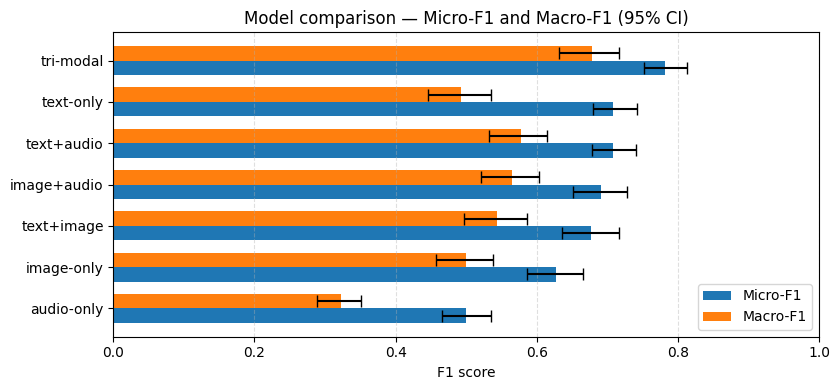

In [ ]:
# Colab cell: plot horizontal bar chart for Micro-F1 and Macro-F1 with 95% CIs
# Reads: /content/analysis_outputs/summary_with_CIs.csv
# Saves: /content/analysis_outputs/f1_comparison.png

!pip install -q matplotlib pandas numpy

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

CSV = "/content/analysis_outputs/summary_with_CIs.csv"
if not os.path.exists(CSV):
    raise FileNotFoundError(f"{CSV} not found. Run the bootstrap CI cell first.")

df = pd.read_csv(CSV)
# order by micro_f1 descending for plotting
df = df.sort_values("micro_f1", ascending=True)  # ascending for horizontal bars (bottom-up)

models = df["model"].tolist()
y_pos = np.arange(len(models))

# micro & macro and their error extents
micro = df["micro_f1"].values
micro_err_low = micro - df["micro_ci_low"].values
micro_err_high = df["micro_ci_high"].values - micro
micro_err = np.vstack([micro_err_low, micro_err_high])

macro = df["macro_f1"].values
macro_err_low = macro - df["macro_ci_low"].values
macro_err_high = df["macro_ci_high"].values - macro
macro_err = np.vstack([macro_err_low, macro_err_high])

fig, ax = plt.subplots(figsize=(8.5, max(4, 0.5*len(models))))
bar_height = 0.35

# plot micro bars
ax.barh(y_pos - bar_height/2, micro, height=bar_height, xerr=micro_err, align='center',
        label='Micro-F1', ecolor='black', capsize=4)

# plot macro bars
ax.barh(y_pos + bar_height/2, macro, height=bar_height, xerr=macro_err, align='center',
        label='Macro-F1', ecolor='black', capsize=4)

ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.set_xlabel("F1 score")
ax.set_xlim(0.0, 1.0)
ax.set_title("Model comparison — Micro-F1 and Macro-F1 (95% CI)")
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.legend(loc='lower right')

plt.tight_layout()
out_png = "/content/analysis_outputs/f1_comparison.png"
plt.savefig(out_png, dpi=300, bbox_inches='tight')
print("Saved figure to", out_png)
plt.show()
